In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error

import functools
import evidential_deep_learning as edl

tf.__version__

2023-03-31 09:56:12.844879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 09:56:12.931365: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 09:56:13.340201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-31 09:56:13.340244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [3]:
# Load dataset
csv_file = '../Dataset/dataset_augmented.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
3,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
4,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11


In [4]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
3,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
4,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140


2
64
272
80
80


(array([  2.,  64., 272.,  80.,  80.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

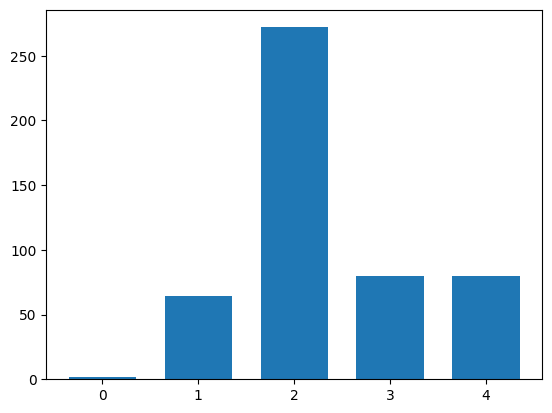

In [5]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [6]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,498.0,0.353414,0.959753,0.00000,0.0000,0.0000,0.0000,4.0000
Pos2,498.0,0.427711,1.080183,0.00000,0.0000,0.0000,0.0000,4.0000
Pos3,498.0,0.363454,0.990107,0.00000,0.0000,0.0000,0.0000,4.0000
Pos4,498.0,0.331325,0.943400,0.00000,0.0000,0.0000,0.0000,4.0000
Pos5,498.0,0.383534,1.000749,0.00000,0.0000,0.0000,0.0000,4.0000
Pos6,498.0,0.321285,0.917738,0.00000,0.0000,0.0000,0.0000,4.0000
Pos7,498.0,0.339357,0.946930,0.00000,0.0000,0.0000,0.0000,4.0000
Pos8,498.0,0.417671,1.022016,0.00000,0.0000,0.0000,0.0000,4.0000
Pos9,498.0,0.417671,1.022016,0.00000,0.0000,0.0000,0.0000,4.0000
Pos10,498.0,0.339357,0.946930,0.00000,0.0000,0.0000,0.0000,4.0000


In [7]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,496.0,0.354839,0.961426,0.0000,0.000000,0.00000,0.00000,4.0000
Pos2,496.0,0.429435,1.082020,0.0000,0.000000,0.00000,0.00000,4.0000
Pos3,496.0,0.364919,0.991835,0.0000,0.000000,0.00000,0.00000,4.0000
Pos4,496.0,0.318548,0.922961,0.0000,0.000000,0.00000,0.00000,4.0000
Pos5,496.0,0.381048,0.999982,0.0000,0.000000,0.00000,0.00000,4.0000
Pos6,496.0,0.322581,0.919362,0.0000,0.000000,0.00000,0.00000,4.0000
Pos7,496.0,0.340726,0.948595,0.0000,0.000000,0.00000,0.00000,4.0000
Pos8,496.0,0.413306,1.017297,0.0000,0.000000,0.00000,0.00000,4.0000
Pos9,496.0,0.413306,1.017297,0.0000,0.000000,0.00000,0.00000,4.0000
Pos10,496.0,0.340726,0.948595,0.0000,0.000000,0.00000,0.00000,4.0000


In [8]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,496.0,3.548387e-01,0.961426,0.000000,0.000000,0.000000,0.000000,4.000000
Pos2,496.0,4.294355e-01,1.082020,0.000000,0.000000,0.000000,0.000000,4.000000
Pos3,496.0,3.649194e-01,0.991835,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,496.0,3.185484e-01,0.922961,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,496.0,3.810484e-01,0.999982,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,496.0,3.225806e-01,0.919362,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,496.0,3.407258e-01,0.948595,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,496.0,4.133065e-01,1.017297,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,496.0,4.133065e-01,1.017297,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,496.0,3.407258e-01,0.948595,0.000000,0.000000,0.000000,0.000000,4.000000


In [9]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets

### IMPORTANT: Select for normalization
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

396 training examples
50 validation examples
50 test examples


In [10]:
# Create an input pipeline using tf.data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Example: 
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Pos1:', train_features['Pos1'])
print('A batch of targets (R):', label_batch )

Every feature: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'target']
A batch of Pos1: tf.Tensor([[0]], shape=(1, 1), dtype=int64)
A batch of targets (R): tf.Tensor([1.3629786], shape=(1,), dtype=float64)


/tmp/ipykernel_48765/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2023-03-31 09:57:52.085861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 09:57:52.115953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-31 09:57:52.115977: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guid

In [11]:
# Numerical columns preprocessing layer

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
# Categorical columns preprocessing layer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [13]:
# Create an input pipeline
batch_size = 2
# shuffle is set to False, as it was already done before
#train_ds = df_to_dataset(train, batch_size=batch_size)
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_48765/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_48765/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [14]:
# Preprocess selected features (categorical and numerical)

all_inputs = []
encoded_features = []

# Multi-hot encoding and add the resulting feature inputs to encoded_features
categorical_cols = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 
                    'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 
                    'Pos13', 'Pos14', 'Pos15', 'Pos16']
#categorical_cols= list(train_features.keys())
#categorical_cols = categorical_cols[0:16]
print("Categorical cols: "+str(categorical_cols))
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Normalize numerical features.
""" numeric_cols = ['X', 'Y', 'Z']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

""" numeric_cols = ['target']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

Categorical cols: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


' numeric_cols = [\'target\']\nprint("Numerical cols: "+str(numeric_cols))\nfor header in numeric_cols:\n  numeric_col = tf.keras.Input(shape=(1,), name=header)\n  normalization_layer = get_normalization_layer(header, train_ds)\n  encoded_numeric_col = normalization_layer(numeric_col)\n  all_inputs.append(numeric_col)\n  encoded_features.append(encoded_numeric_col) '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos3 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos4 (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

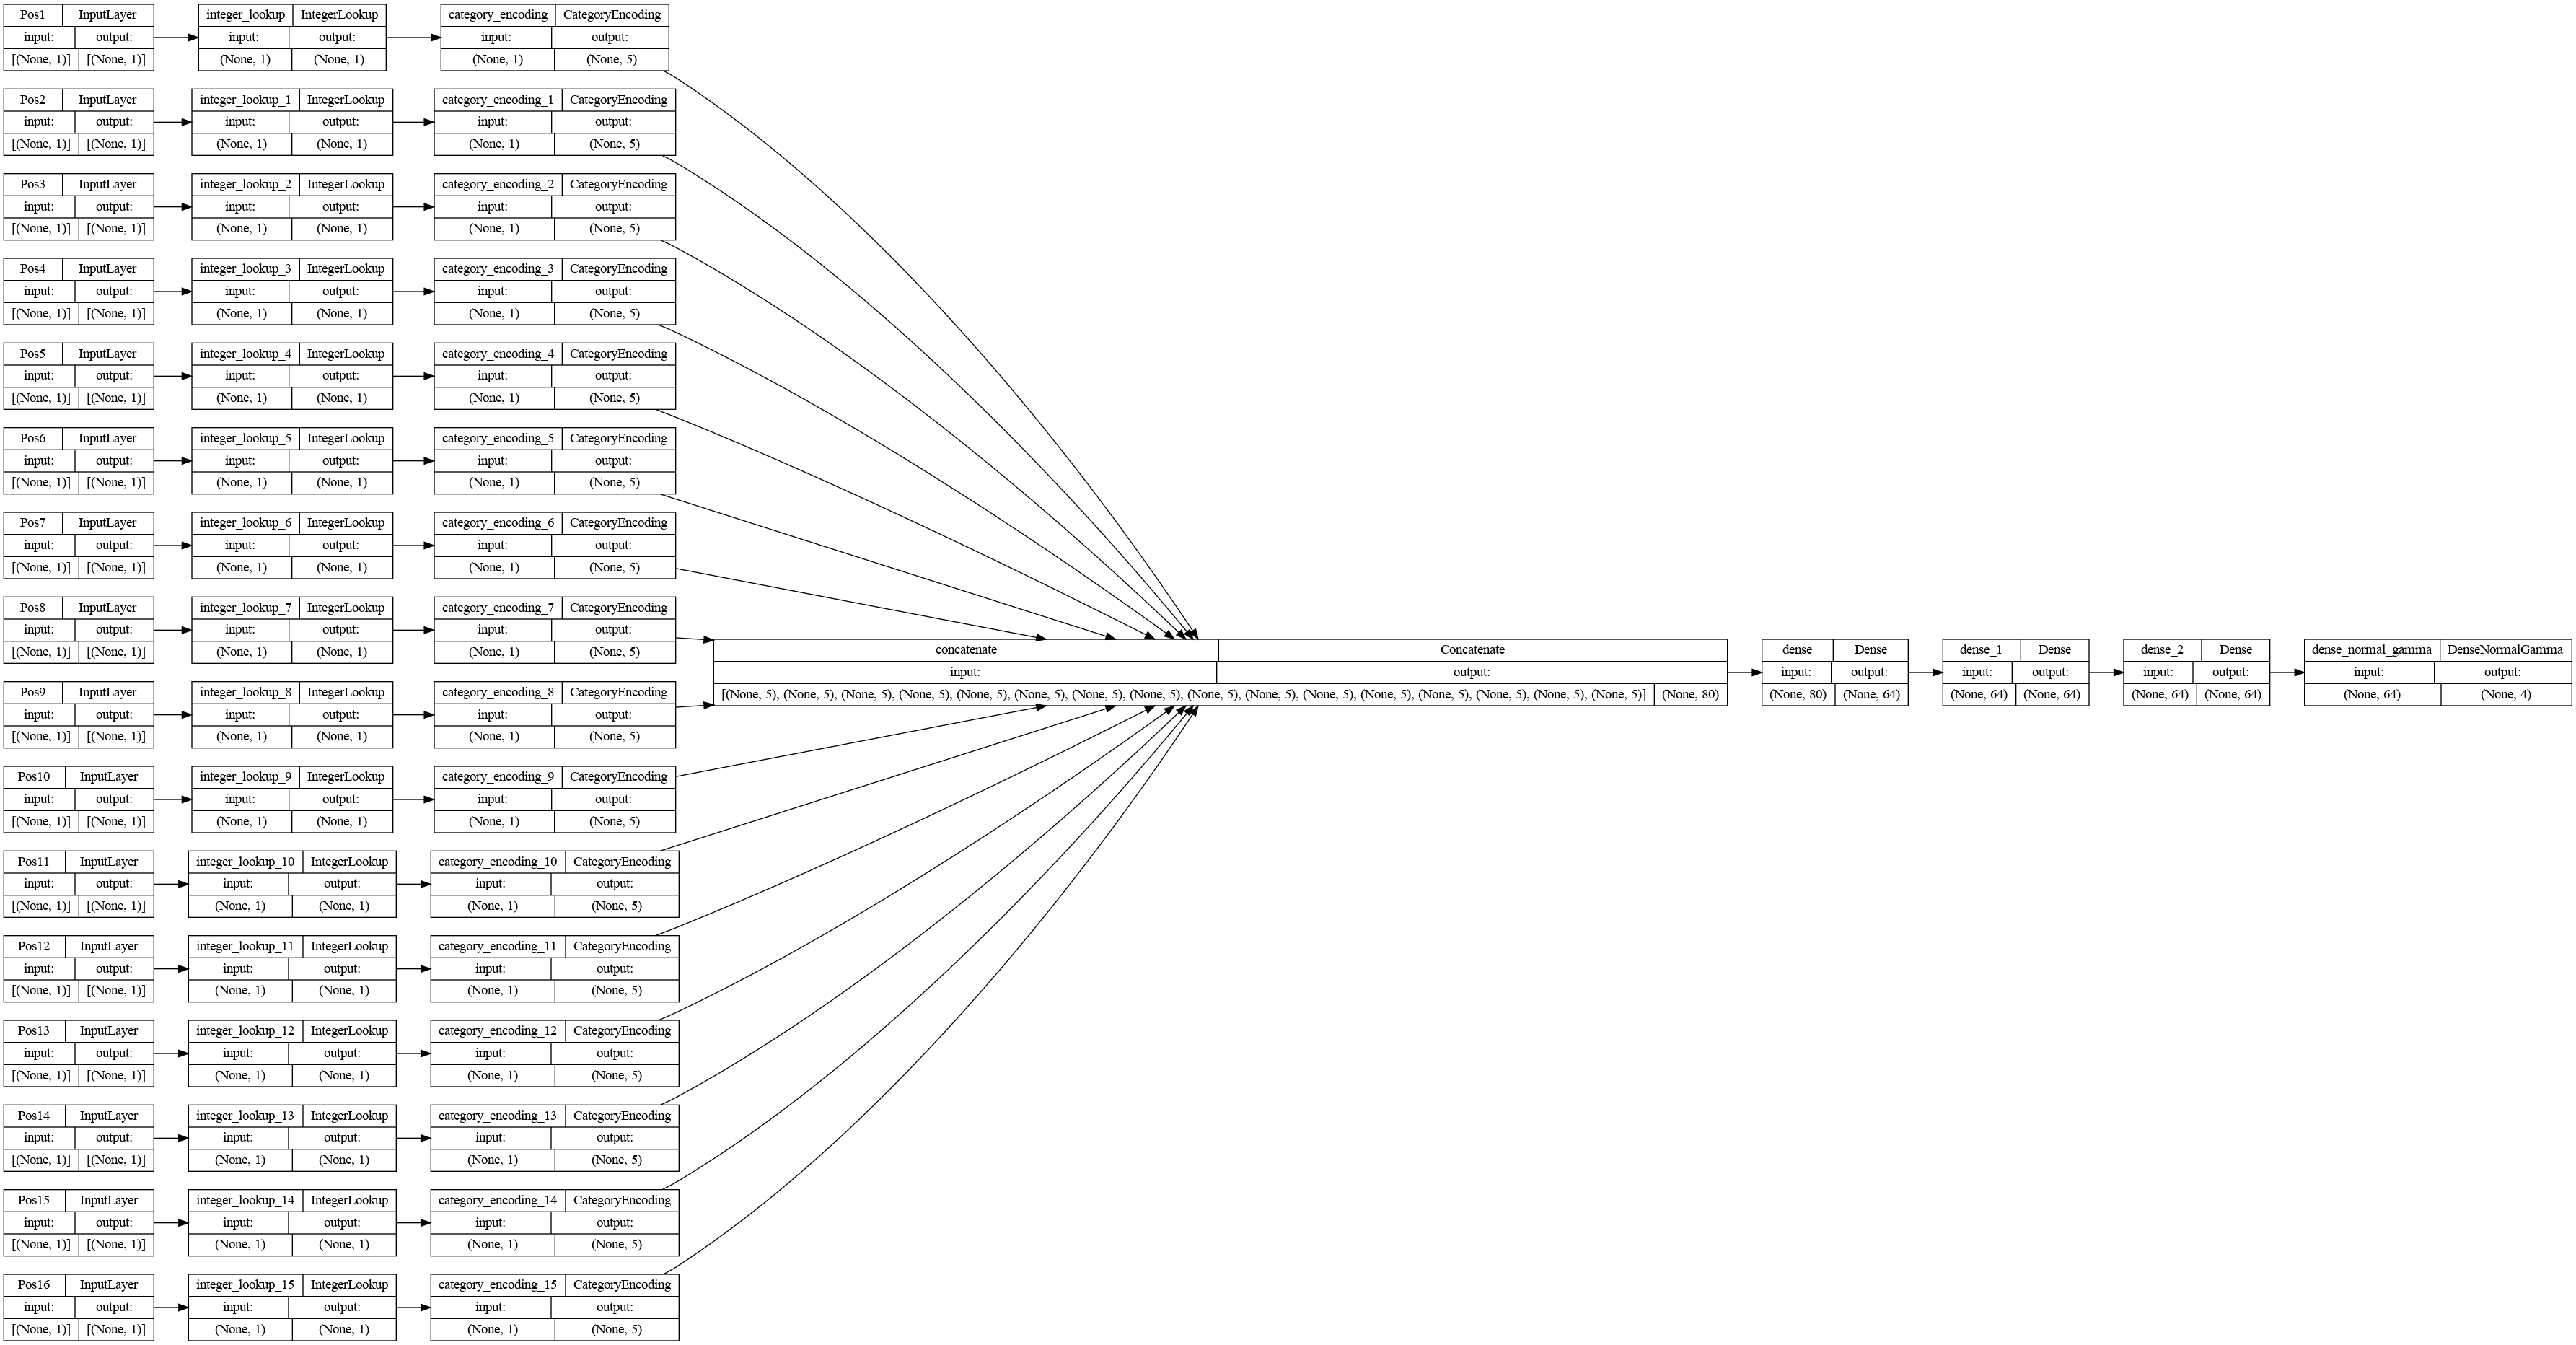

In [15]:
# Create the model architecture
all_features = tf.keras.layers.concatenate(encoded_features)

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

#output = tf.keras.layers.Dense(1)(x)
output = edl.layers.DenseNormalGamma(1)(x)

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #loss=tf.keras.losses.MeanAbsoluteError(),
              loss=EvidentialRegressionLoss,
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [16]:
# Train the model
history = model.fit(train_ds, epochs=300, verbose=2, validation_data=val_ds)


Epoch 1/300


/home/alfonso/Work/UGR/Calculations/Helicenes_GNNs/Helicenes_venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


198/198 - 2s - loss: 1.4548 - val_loss: 1.5245 - 2s/epoch - 8ms/step
Epoch 2/300
198/198 - 0s - loss: 1.3668 - val_loss: 1.4735 - 210ms/epoch - 1ms/step
Epoch 3/300
198/198 - 0s - loss: 1.2829 - val_loss: 1.4065 - 210ms/epoch - 1ms/step
Epoch 4/300
198/198 - 0s - loss: 1.1810 - val_loss: 1.3158 - 224ms/epoch - 1ms/step
Epoch 5/300
198/198 - 0s - loss: 1.0540 - val_loss: 1.2033 - 208ms/epoch - 1ms/step
Epoch 6/300
198/198 - 0s - loss: 0.9144 - val_loss: 1.0944 - 215ms/epoch - 1ms/step
Epoch 7/300
198/198 - 0s - loss: 0.7824 - val_loss: 1.0075 - 236ms/epoch - 1ms/step
Epoch 8/300
198/198 - 0s - loss: 0.6660 - val_loss: 0.9484 - 224ms/epoch - 1ms/step
Epoch 9/300
198/198 - 0s - loss: 0.5666 - val_loss: 0.9137 - 209ms/epoch - 1ms/step
Epoch 10/300
198/198 - 0s - loss: 0.4814 - val_loss: 0.8986 - 208ms/epoch - 1ms/step
Epoch 11/300
198/198 - 0s - loss: 0.4066 - val_loss: 0.8868 - 204ms/epoch - 1ms/step
Epoch 12/300
198/198 - 0s - loss: 0.3432 - val_loss: 0.8738 - 211ms/epoch - 1ms/step
Epoc

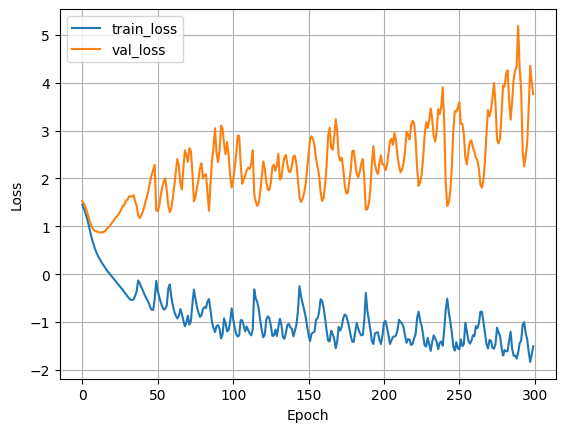

In [17]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [18]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=8)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

def plot_PredvsTrue_error(y_true, y_pred, y_error):

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    plt.errorbar(y_true, y_pred, yerr=y_error, label='Pred',fmt="o")
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.xlim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.ylim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.show() 

""" def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    #plt.scatter(y_true,mu,color="blue",label="Pred",s=6)
    plt.errorbar(y_true, mu, yerr=5*var, label='Pred',fmt="o")
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.xlim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.ylim(p1-0.1*np.abs(p1), p2+0.1*np.abs(p2))    
    plt.show()     """

' def plot_PredvsTrue(y_true, y_pred, n_stds=2):\n\n    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)\n    mu = mu[:, 0]\n    var = np.sqrt(beta / (v * (alpha - 1)))\n    var = np.minimum(var, 1e3)[:, 0]  # for visualization\n    #y_true = y_true[:,0]\n\n    plt.figure(figsize=(5, 5), dpi=200)\n    p1 = min(y_true)\n    p2 = max(y_true)\n    #p1 = 0\n    #p2 = 64\n    #p1 = max(max(y_pred), max(y_true))\n    #p2 = min(min(y_pred), min(y_true))\n    plt.plot([p1, p2], [p1, p2], \'r--\', label="True")\n    #plt.plot(y_true, y_true, \'r--\', zorder=2, label="True")\n    #plt.plot(y_true, mu, color=\'#007cab\', zorder=3, label="Pred")\n    #plt.scatter(y_true,mu,color="blue",label="Pred",s=6)\n    plt.errorbar(y_true, mu, yerr=5*var, label=\'Pred\',fmt="o")\n    #plt.gca().set_xlim(-200, 200)\n    #plt.gca().set_ylim(-200, 200)\n    #plt.gca().set_xlim(0.8*p1, 1.1*p2)\n    #plt.gca().set_ylim(0.9*p1, 1.1*p2)\n    plt.xlabel(\'True\',fontsize=15)\n    plt.ylabel(\'Pred\',fontsize=15)\n 

25/25 [==============================] - 0s 910us/step
(50, 4)
(50,)
(50,)


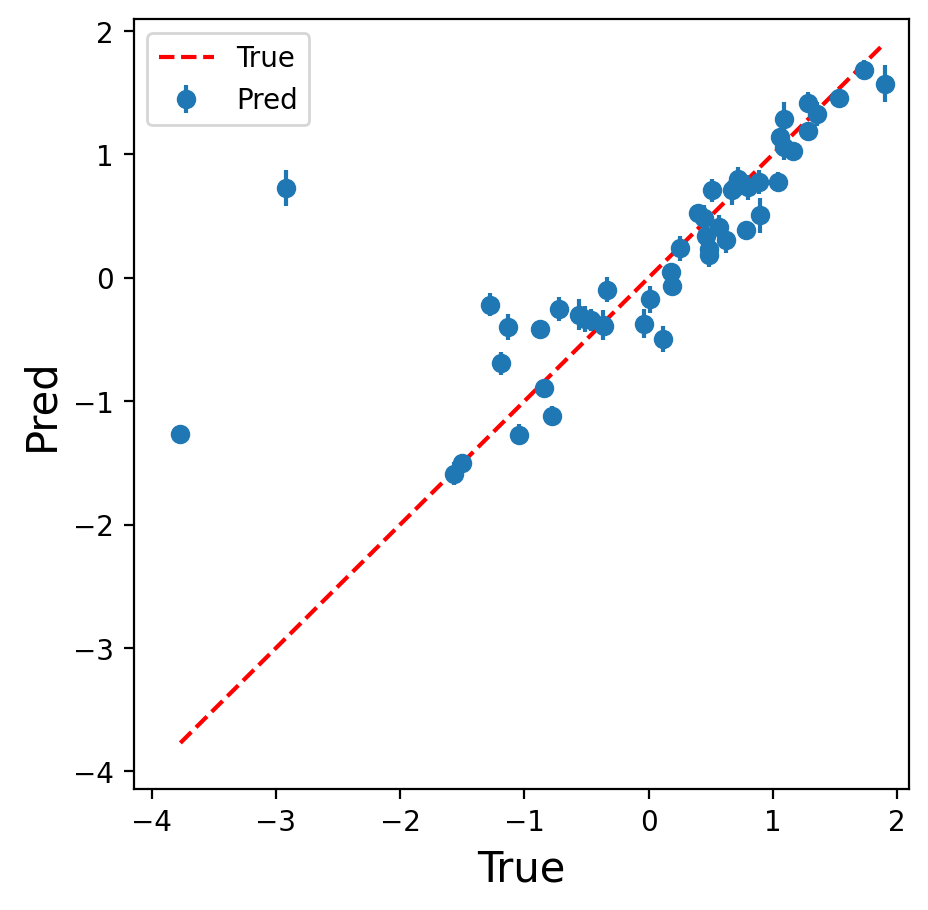

Test MAE: 0.32921300311437773


In [19]:
# Pred vs True values on test set 

v_pred = model.predict(test_ds)
print(v_pred.shape)
mu, v, alpha, beta = tf.split(v_pred, 4, axis=-1)
y_pred = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
y_error = 3*var[:,0]
y_true = np.zeros(len(test['target']))
y_true[:] = test['target']

print(y_true.shape)
print(y_pred.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, y_error)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

198/198 [==============================] - 0s 902us/step
(396, 4)
(396,)
(396,)


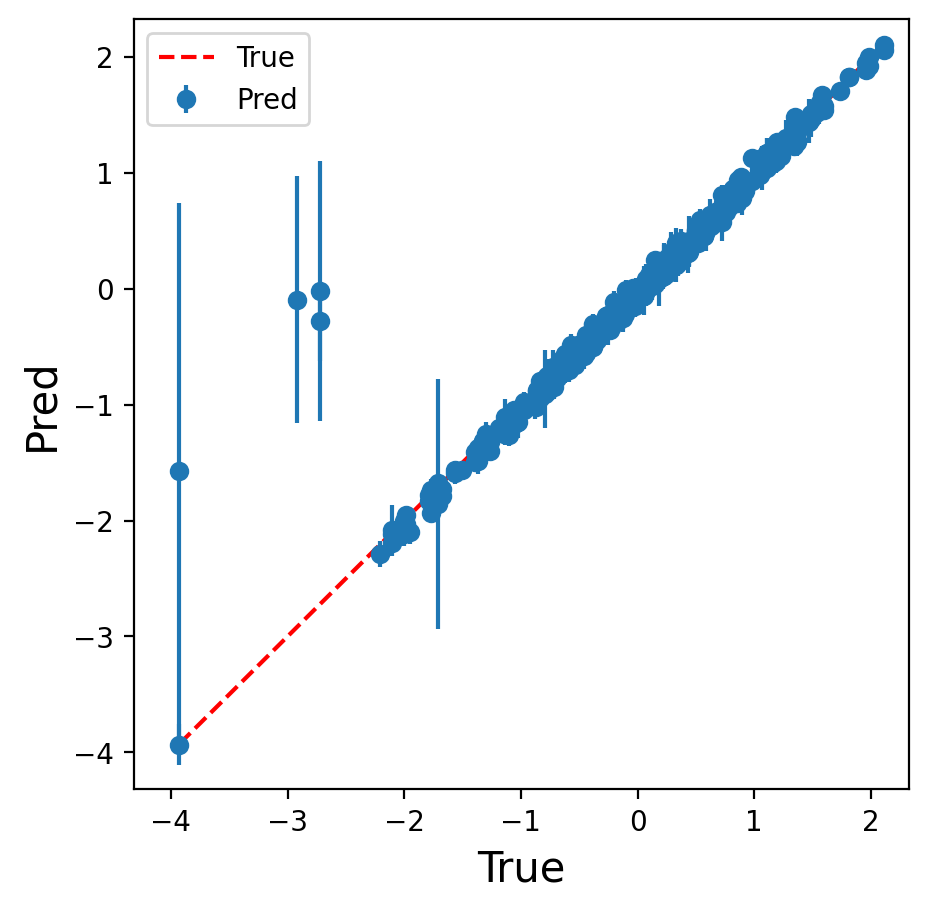

Train MAE: 0.0817817771640567


In [20]:
# Pred vs True values on training set 

v_pred = model.predict(train_ds)
print(v_pred.shape)

y_true = np.zeros(len(train['target']))
y_true[:] = train['target']
mu, v, alpha, beta = tf.split(v_pred, 4, axis=-1)
y_pred = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
y_error = 3*var[:,0]

print(y_true.shape)
print(y_pred.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, y_error)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

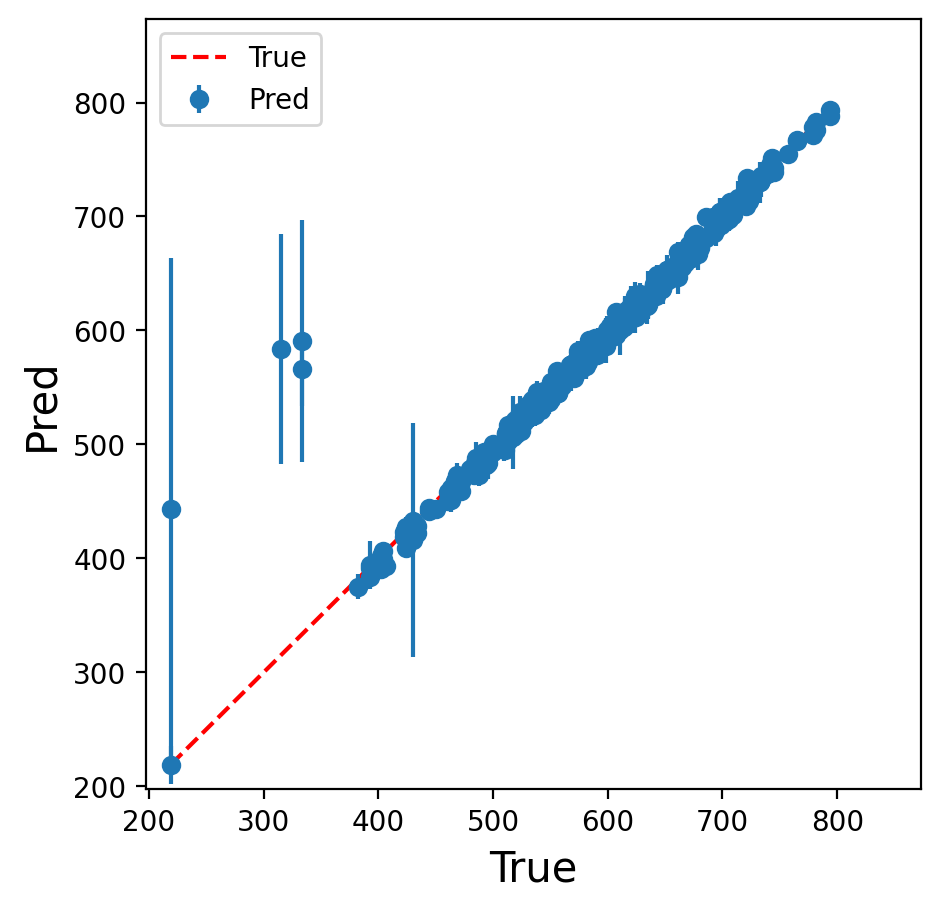

Train MAE (non-normalized): 7.779323988912562


In [21]:
# Evaluate the model with non-normalized units

y_true_units = y_true * R_std + R_mean
y_pred_units = y_pred * R_std + R_mean
y_error_units = y_error * R_std

#plot_PredvsTrue(y_true_units, y_pred_units)
plot_PredvsTrue_error(y_true_units, y_pred_units, y_error_units)

test_mae = mean_absolute_error(y_true_units,y_pred_units)
print("Train MAE (non-normalized): "+str(test_mae))

In [65]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

INFO:tensorflow:Assets written to: R_model_good_medium/assets


INFO:tensorflow:Assets written to: R_model_good_medium/assets


25/25 [==============================] - 0s 818us/step


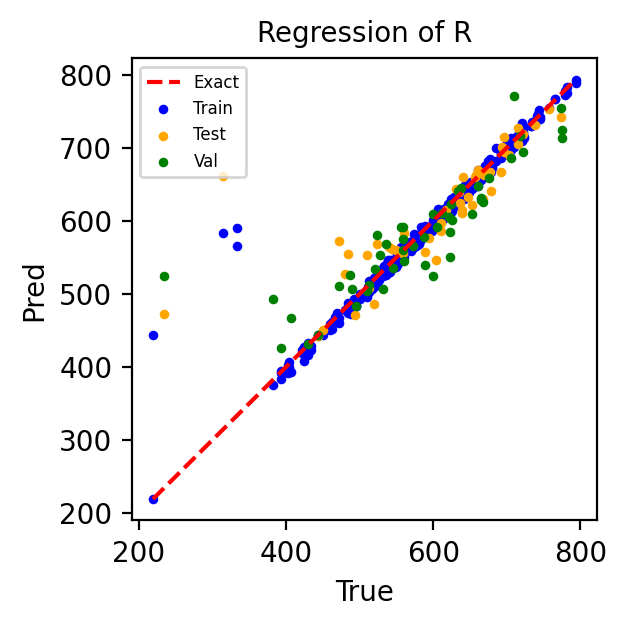

train MAE (non-normalized): 7.779323988912562
test MAE (non-normalized): 31.315722331054687
val MAE (non-normalized): 32.60499628613282


In [22]:
# Evaluate the model with non-normalized units on the whole dataset

v_pred_test = model.predict(test_ds)
mu, v, alpha, beta = tf.split(v_pred_test, 4, axis=-1)
y_pred_test = mu[:, 0]
y_true_test = np.zeros(len(test['target']))
y_true_test[:] = test['target']

v_pred_train = model.predict(train_ds)
mu, v, alpha, beta = tf.split(v_pred_train, 4, axis=-1)
y_pred_train = mu[:, 0]
y_true_train = np.zeros(len(train['target']))
y_true_train[:] = train['target']

v_pred_val = model.predict(val_ds)
mu, v, alpha, beta = tf.split(v_pred_val, 4, axis=-1)
y_pred_val = mu[:, 0]
y_true_val = np.zeros(len(val['target']))
y_true_val[:] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
#y_true_test = y_true_test.ravel()
#y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
#y_true_train = y_true_train.ravel()
#y_pred_train = y_pred_train.ravel()

y_true_val = y_true_val * R_std + R_mean
y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
val_mae = mean_absolute_error(y_true_val,y_pred_val)
print("val MAE (non-normalized): "+str(val_mae))

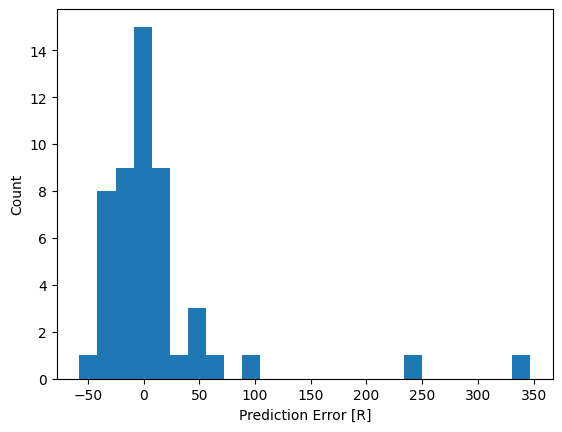

In [23]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


In [24]:
y_pred = np.concatenate((y_pred_train,y_pred_test,y_pred_val))
y_true = np.concatenate((y_true_train,y_true_test,y_true_val))
#print(y_true.shape)
#print(y_pred.shape)
#print(y_true)
#print(y_pred)
y_true = y_true.ravel()
y_pred = y_pred.ravel()
#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

# explore data

data = dataset.to_numpy()

#print()
print("Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)")

error_nhalogens = np.zeros(4)
num_nhalogens = np.zeros(4)
error_halogentype = np.zeros(4)
num_halogentype = np.zeros(4)

for i in range(len(y_pred)):
    diff = abs(y_pred[i]-y_true[i])
    x_data = data[i,0:15]
    n_halogens = np.count_nonzero(x_data)
    #print(data[i,0:15])
    #print(n_halogens)

    error_nhalogens[n_halogens-1] = error_nhalogens[n_halogens-1] + diff
    num_nhalogens[n_halogens-1] = num_nhalogens[n_halogens-1] + 1

    print(str(i)+"  "+str(n_halogens)+"  "+str(y_true[i])+"  "+str(y_pred[i])+"  "+str(diff))


error_nhalogens[:] = error_nhalogens[:] / num_nhalogens[:]
print()
print("Mean Absolute Error (MAE) according to nº halogens: 1 halogen, 2 halogens, 3 halogens, 4 halogens")
print(error_nhalogens)

Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)
0  2  588.9975  586.90424  2.0932641601561954
1  2  422.3459  423.56143  1.215531884765653
2  4  558.1551  555.8744  2.2807103515624476
3  2  613.8408  614.76184  0.9210408203125553
4  2  589.0005  593.2181  4.217578613281262
5  3  599.5056  597.40924  2.0963592773437085
6  1  404.2231  406.59103  2.367933935546887
7  1  512.4159  511.03552  1.380377539062465
8  2  676.9635  684.63354  7.670044921875046
9  4  599.4318  598.49927  0.9325324218749529
10  3  593.8145  591.9412  1.8732768554687027
11  1  602.0896  603.80804  1.7184444335937314
12  2  556.0587  564.10596  8.047257031249956
13  2  614.6289  614.0039  0.6249937500000442
14  2  219.15390000000002  218.57166  0.5822447265625215
15  2  588.7641  587.814  0.9500741210937349
16  1  430.223  433.12628  2.903281738281237
17  3  484.8454  487.77362  2.9282206054687663
18  4  424.0839  427.61078  3.5268788085937217
19  3  524.0781  521.811  2.2671258789061994
20  2  466.4233  46